<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<br><h2>Kaggle Submission Template</h2>
<h4>DAT-5390 | Computational Data Analytics with Python</h4>
Chase Kusterer - Faculty of Analytics<br>
Hult International Business School<br><br><br>

<hr style="height:.9px;border:none;color:#333;background-color:#333;" />
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<br>

<h3>The Purpose of the Notebook</h3><br>
This Notebook is organized as a template for submitting on Kaggle. It will output a .csv file that can be submitted via Kaggle.<br><br>
Remember that you also need to provide an analysis alongside your model building via the assignment link on the course page. Start by conducting your analysis and then copy/paste relevant code to this template (missing value imputation, feature engineering, etc.). Please do not submit this template as your analysis (many of the technical steps are not necessary for the analysis). Finally, on the course page, make sure to submit your analysis and model development as one document in two formats (Jupyter Notebook and a .txt file).
<br><br>
<hr style="height:.9px;border:none;color:#333;background-color:#333;" />

<h3>Reminder: Model Analysis Tips</h3><br>
<strong>How fit should a model be?</strong><br>
As a general heuristic, if the training and testing scores are within 0.05 of each other, the model has not been overfit. Don't worry if the testing score ends up higher than the training score. Some sources claim that in such situations a model is underfit, but this is a general misconception that is beyond the scope of this course. For this course, long as the training and testing scores are within 0.05 of each other, the model is good to go.
<br><br>

<strong>Which model should I choose?</strong><br>
All models have their own benefits and drawbacks. Thus, it is important to test out more than one and to also explore their <a href="https://scikit-learn.org/stable/modules/classes.html#classical-linear-regressors">documentation</a>.

<hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

<h2>Part I: Imports and Data Check</h2>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik   
import time
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import power_transform    
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight


# Load data
df_train = pd.read_csv("../kaggle_competition/birthweight.csv")
df_test = pd.read_csv('../kaggle_competition/kaggle_test_data.csv')

# Mark datasets before concatenation
df_train['set'] = 'Not Kaggle'
df_test ['set'] = 'Kaggle'

# Concatenate datasets for easier preprocessing
df_full = pd.concat([df_train, df_test], axis=0, ignore_index=False)

df_full.head(n=10)

,bwt_id,mage,meduc,monpre,npvis,fage,feduc,omaps,fmaps,cigs,drink,male,mwhte,mblck,moth,fwhte,fblck,foth,bwght,set
0,bwt_1,28,12.0,2,10.0,31.0,17.0,8.0,9.0,0.0,0.0,0,1,0,0,1,0,0,3317.0,Not Kaggle
1,bwt_2,21,NaN,1,6.0,21.0,NaN,8.0,9.0,NaN,NaN,0,1,0,0,1,0,0,1160.0,Not Kaggle
2,bwt_3,27,15.0,2,11.0,32.0,16.0,9.0,9.0,0.0,0.0,1,1,0,0,1,0,0,4706.0,Not Kaggle
3,bwt_4,33,17.0,1,20.0,39.0,17.0,9.0,10.0,0.0,0.0,0,0,0,1,0,0,1,3289.0,Not Kaggle
4,bwt_5,30,15.0,2,12.0,36.0,16.0,9.0,9.0,NaN,NaN,1,1,0,0,1,0,0,3490.0,Not Kaggle
5,bwt_6,29,16.0,1,12.0,32.0,16.0,8.0,9.0,0.0,0.0,0,1,0,0,1,0,0,3345.0,Not Kaggle
6,bwt_7,31,12.0,2,12.0,31.0,12.0,9.0,9.0,0.0,0.0,0,1,0,0,1,0,0,3030.0,Not Kaggle
7,bwt_8,28,12.0,1,13.0,31.0,14.0,8.0,9.0,0.0,0.0,0,1,0,0,1,0,0,3771.0,Not Kaggle
8,bwt_9,24,12.0,2,15.0,25.0,12.0,8.0,9.0,0.0,0.0,1,1,0,0,1,0,0,1660.0,Not Kaggle
9,bwt_10,28,16.0,1,12.0,32.0,12.0,8.0,9.0,0.0,0.0,0,1,0,0,1,0,0,1786.0,Not Kaggle


In [2]:
#Data Exploration
# checking available features
df_full.columns

Index(['bwt_id', 'mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'omaps',
       'fmaps', 'cigs', 'drink', 'male', 'mwhte', 'mblck', 'moth', 'fwhte',
       'fblck', 'foth', 'bwght', 'set'],
      dtype='object')

In [3]:
df_full.isnull().sum()

bwt_id     0
mage       0
meduc      6
monpre     0
npvis     21
fage       1
feduc     10
omaps      2
fmaps      2
cigs      33
drink     32
male       0
mwhte      0
mblck      0
moth       0
fwhte      0
fblck      0
foth       0
bwght     64
set        0
dtype: int64

In [4]:
# Fill missing values for 'meduc' and 'feduc' with their mode
for column in ['meduc', 'feduc']:
    df_full[column].fillna(df_full[column].mode()[0], inplace=True)

# Fill missing values for 'npvis', 'fage', 'omaps', 'fmaps' with their median
for column in ['npvis', 'fage', 'omaps', 'fmaps']:
    df_full[column].fillna(df_full[column].median(), inplace=True)

# Fill missing values for 'cigs', 'drink' with 0
df_full['cigs'].fillna(0, inplace=True)
df_full['drink'].fillna(0, inplace=True)

# Calculate the mean of the 'bwght' column, excluding NaN values
mean_bwght = df_full['bwght'].mean()

# Replace missing values in 'bwght' with the calculated mean
df_full['bwght'].fillna(value=mean_bwght, inplace=True)

In [5]:
df_full.isnull().sum()

bwt_id    0
mage      0
meduc     0
monpre    0
npvis     0
fage      0
feduc     0
omaps     0
fmaps     0
cigs      0
drink     0
male      0
mwhte     0
mblck     0
moth      0
fwhte     0
fblck     0
foth      0
bwght     0
set       0
dtype: int64

In [6]:
#!##############################!#
#!# set your response variable #!#
#!##############################!#
y_variable = "low_bwght" # this should be a string

In [7]:
# Information about each variable
df_full.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Index: 473 entries, 0 to 63
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   bwt_id  473 non-null    object 
 1   mage    473 non-null    int64  
 2   meduc   473 non-null    float64
 3   monpre  473 non-null    int64  
 4   npvis   473 non-null    float64
 5   fage    473 non-null    float64
 6   feduc   473 non-null    float64
 7   omaps   473 non-null    float64
 8   fmaps   473 non-null    float64
 9   cigs    473 non-null    float64
 10  drink   473 non-null    float64
 11  male    473 non-null    int64  
 12  mwhte   473 non-null    int64  
 13  mblck   473 non-null    int64  
 14  moth    473 non-null    int64  
 15  fwhte   473 non-null    int64  
 16  fblck   473 non-null    int64  
 17  foth    473 non-null    int64  
 18  bwght   473 non-null    float64
 19  set     473 non-null    object 
dtypes: float64(9), int64(9), object(2)
memory usage: 77.6+ KB


C:\Users\fquin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\fquin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


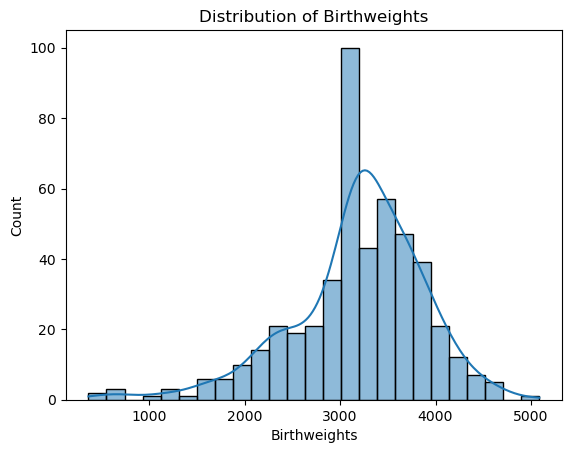

In [8]:
#All explanations from visualizations requested from rubric are in the analysis sections below.

#Exploration of the distribution of bwght
sns.histplot(data   = df_full,
             x      = 'bwght',
             kde    = True)


# title and axis labels
plt.title(label   = "Distribution of Birthweights")
plt.xlabel(xlabel = "Birthweights")
plt.ylabel(ylabel = "Count")

# displaying the histogram
plt.show()

C:\Users\fquin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\fquin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\fquin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='cigs', ylabel='bwght'>

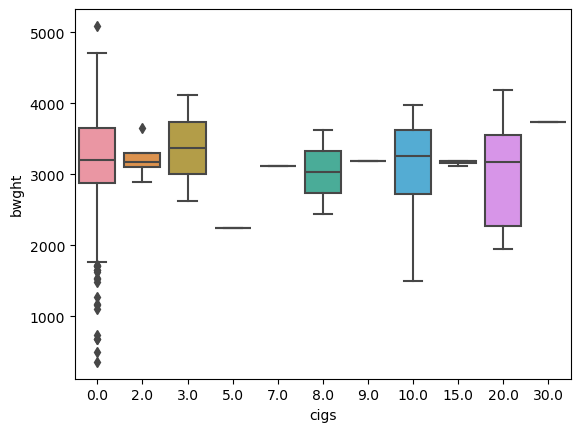

In [9]:
#Boxplot for cigs and birthweights
sns.boxplot(x = 'cigs', y = 'bwght', data = df_full)

C:\Users\fquin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\fquin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\fquin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='npvis', ylabel='bwght'>

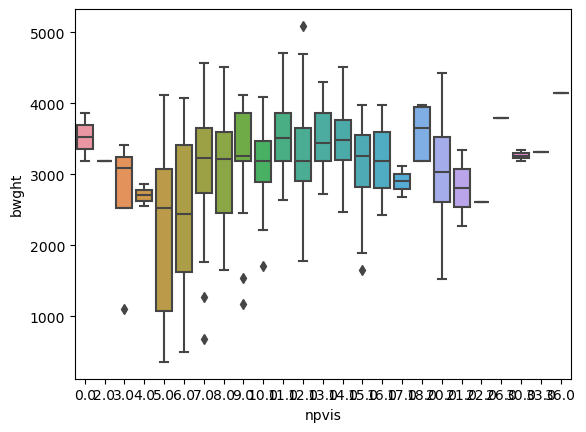

In [10]:
#Boxplot for npvis and birthweights
sns.boxplot(x = "npvis", y = 'bwght', data = df_full)

In [11]:
# Filter out non-numeric columns
df_numeric = df_full.select_dtypes(include=[np.number])

# Calculate Pearson correlation coefficient for the remaining numeric columns
df_full_corr = df_numeric.corr(method='pearson').round(decimals=4)

# Check results for 'bwght' column, sorting in descending order
df_full_corr_bwght = df_full_corr.loc[:, 'bwght'].sort_values(ascending=False)

df_full_corr_bwght

bwght     1.0000
omaps     0.3670
fmaps     0.3470
npvis     0.1663
fage      0.1297
feduc     0.0580
male      0.0568
monpre    0.0514
mage      0.0510
fblck     0.0387
mblck     0.0213
fwhte     0.0157
mwhte     0.0143
meduc     0.0003
drink    -0.0254
cigs     -0.0279
moth     -0.0454
foth     -0.0711
Name: bwght, dtype: float64

In [12]:
# using the phi coefficient for correlation
df_full_phi_corr = df_full.phik_matrix().round(decimals = 4)


# checking results
df_full_phi_corr.loc[ : , 'bwght' ].sort_values(ascending = False)

interval columns not set, guessing: ['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 'omaps', 'fmaps', 'cigs', 'drink', 'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 'foth', 'bwght']


bwt_id    1.0000
bwght     1.0000
set       0.7408
omaps     0.5417
fmaps     0.5202
npvis     0.3459
fage      0.3399
feduc     0.3293
male      0.0720
monpre    0.0660
moth      0.0627
mwhte     0.0578
foth      0.0275
mage      0.0000
cigs      0.0000
mblck     0.0000
fwhte     0.0000
fblck     0.0000
meduc     0.0000
drink     0.0000
Name: bwght, dtype: float64

<br><h3>Feature Engineering</h3>

In [13]:
# Create a new column 'low_bwght' based on the 2500 gram threshold
df_full['low_bwght'] = (df_full['bwght'] < 2500).astype(int)

# Dropping the 'omaps' and 'fmaps' columns from the dataframe
df_full.drop(['omaps', 'fmaps'], axis=1, inplace=True)

# Function to bin values for 'cigs' and 'drink'
def bin_values(value):
    if pd.isnull(value):
        return 'Unknown'
    elif value == 0:
        return 'None'
    elif 1 <= value <= 5:
        return 'Low'
    elif 6 <= value <= 10:
        return 'Moderate'
    else:
        return 'High'

# Applying the binning function to 'cigs' and 'drink' and creating new columns
df_full['cigs_binned'] = df_full['cigs'].apply(bin_values)
df_full['drink_binned'] = df_full['drink'].apply(bin_values)

# Interaction Term: Father's age and number of prenatal visits
df_full['fage_npvis_interaction'] = df_full['fage'] * df_full['npvis']

# Aggregated Feature: Parents' average education level
df_full['parents_avg_educ'] = (df_full['feduc'] + df_full['meduc']) / 2

# Binary Features: Mother's and Father's occupation presence
df_full['moth_present'] = df_full['moth'].apply(lambda x: 0 if pd.isnull(x) or x == 0 else 1)
df_full['foth_present'] = df_full['foth'].apply(lambda x: 0 if pd.isnull(x) or x == 0 else 1)

#Prenatal Care Index:
df_full['prenatal_care_index'] = df_full['npvis'] * df_full['moth_present']

#Health Index
# Assign numeric values to the binned categories
health_risks = {'None': 0, 'Low': 1, 'Moderate': 2, 'High': 3}

df_full['health_index'] = df_full['cigs_binned'].replace(health_risks) + df_full['drink_binned'].replace(health_risks)

#Socioeconomic Interaction
df_full['socioeconomic_interaction'] = df_full['moth_present'] * df_full['foth_present']

#Age Difference
df_full['age_difference'] = abs(df_full['fage'] - df_full['mage'])

#Parental Age and Education Interaction
df_full['fage_educ_interaction'] = df_full['fage'] * df_full['feduc']
df_full['mage_educ_interaction'] = df_full['mage'] * df_full['meduc']

# Interaction Term: Father's age and number of prenatal visits
df_full['fage_npvis_interaction'] = df_full['fage'] * df_full['npvis']

# Aggregated Feature: Parents' average education level
df_full['parents_avg_educ'] = (df_full['feduc'] + df_full['meduc']) / 2

# Binary Features: Mother's and Father's occupation presence
df_full['moth_present'] = df_full['moth'].apply(lambda x: 0 if pd.isnull(x) or x == 0 else 1)
df_full['foth_present'] = df_full['foth'].apply(lambda x: 0 if pd.isnull(x) or x == 0 else 1)

# Prenatal Care Index:
df_full['prenatal_care_index'] = df_full['npvis'] * df_full['moth_present']

# Health Index
health_risks = {'None': 0, 'Low': 1, 'Moderate': 2, 'High': 3}
df_full['health_index'] = df_full['cigs_binned'].replace(health_risks) + df_full['drink_binned'].replace(health_risks)

# Socioeconomic Interaction
df_full['socioeconomic_interaction'] = df_full['moth_present'] * df_full['foth_present']

# Age Difference
df_full['age_difference'] = abs(df_full['fage'] - df_full['mage'])

# Parental Age and Education Interaction
df_full['fage_educ_interaction'] = df_full['fage'] * df_full['feduc']
df_full['mage_educ_interaction'] = df_full['mage'] * df_full['meduc']

# Prenatal Health Index: A refined health index considering both the number of prenatal visits and health behaviors
# Logic: Higher prenatal visits and lower risk behaviors may indicate better prenatal care and potentially lower risk of low_bwght
df_full['prenatal_health_index'] = (df_full['cigs_binned'].replace(health_risks) +
                                    df_full['drink_binned'].replace(health_risks)) * df_full['npvis']

# Parental Age Group Interaction: Interaction between age groups and education levels
# Logic: Different age groups might have varying impacts when combined with education levels on the low_bwght outcome
df_full['fage_group'] = pd.cut(df_full['fage'], bins=[0, 20, 35, 100], labels=['young', 'middle', 'old'])
df_full['mage_group'] = pd.cut(df_full['mage'], bins=[0, 20, 35, 100], labels=['young', 'middle', 'old'])
df_full['fage_group_educ'] = df_full['fage_group'].astype(str) + "_" + df_full['feduc'].astype(str)
df_full['mage_group_educ'] = df_full['mage_group'].astype(str) + "_" + df_full['meduc'].astype(str)

In [14]:
df_full.head(n=10)

,bwt_id,mage,meduc,monpre,npvis,fage,feduc,cigs,drink,male,...,health_index,socioeconomic_interaction,age_difference,fage_educ_interaction,mage_educ_interaction,prenatal_health_index,fage_group,mage_group,fage_group_educ,mage_group_educ
0,bwt_1,28,12.0,2,10.0,31.0,17.0,0.0,0.0,0,...,0,0,3.0,527.0,336.0,0.0,middle,middle,middle_17.0,middle_12.0
1,bwt_2,21,12.0,1,6.0,21.0,12.0,0.0,0.0,0,...,0,0,0.0,252.0,252.0,0.0,middle,middle,middle_12.0,middle_12.0
2,bwt_3,27,15.0,2,11.0,32.0,16.0,0.0,0.0,1,...,0,0,5.0,512.0,405.0,0.0,middle,middle,middle_16.0,middle_15.0
3,bwt_4,33,17.0,1,20.0,39.0,17.0,0.0,0.0,0,...,0,1,6.0,663.0,561.0,0.0,old,middle,old_17.0,middle_17.0
4,bwt_5,30,15.0,2,12.0,36.0,16.0,0.0,0.0,1,...,0,0,6.0,576.0,450.0,0.0,old,middle,old_16.0,middle_15.0
5,bwt_6,29,16.0,1,12.0,32.0,16.0,0.0,0.0,0,...,0,0,3.0,512.0,464.0,0.0,middle,middle,middle_16.0,middle_16.0
6,bwt_7,31,12.0,2,12.0,31.0,12.0,0.0,0.0,0,...,0,0,0.0,372.0,372.0,0.0,middle,middle,middle_12.0,middle_12.0
7,bwt_8,28,12.0,1,13.0,31.0,14.0,0.0,0.0,0,...,0,0,3.0,434.0,336.0,0.0,middle,middle,middle_14.0,middle_12.0
8,bwt_9,24,12.0,2,15.0,25.0,12.0,0.0,0.0,1,...,0,0,1.0,300.0,288.0,0.0,middle,middle,middle_12.0,middle_12.0
9,bwt_10,28,16.0,1,12.0,32.0,12.0,0.0,0.0,0,...,0,0,4.0,384.0,448.0,0.0,middle,middle,middle_12.0,middle_16.0


<br><h3>Standardization</h3>

In [15]:
# INSTANTIATING a StandardScaler() object
# Selecting only numeric columns for scaling
numeric_cols = df_full.select_dtypes(include=['int64', 'float64']).columns

# INSTANTIATING a StandardScaler() object
scaler = StandardScaler()

# FITTING the scaler with the numeric data
scaler.fit(df_full[numeric_cols])

# TRANSFORMING our data after fit
x_scaled = scaler.transform(df_full[numeric_cols])

# converting scaled data into a DataFrame
x_scaled_df = pd.DataFrame(x_scaled, columns=numeric_cols)

# checking the results
description = x_scaled_df.describe().round(decimals=2)

description

,mage,meduc,monpre,npvis,fage,feduc,cigs,drink,male,mwhte,...,parents_avg_educ,moth_present,foth_present,prenatal_care_index,health_index,socioeconomic_interaction,age_difference,fage_educ_interaction,mage_educ_interaction,prenatal_health_index
count,473.00,473.00,473.00,473.00,473.00,473.00,473.00,473.00,473.00,473.00,...,473.00,473.00,473.00,473.00,473.00,473.00,473.00,473.00,473.00,473.00
mean,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-2.70,-5.01,-1.66,-3.01,-2.33,-3.54,-0.27,-0.07,-1.01,-2.60,...,-4.03,-0.24,-0.23,-0.23,-0.29,-0.22,-0.98,-2.33,-3.09,-0.28
25%,-0.74,-0.78,-0.91,-0.41,-0.69,-0.83,-0.27,-0.07,-1.01,0.38,...,-0.91,-0.24,-0.23,-0.23,-0.29,-0.22,-0.70,-0.73,-0.69,-0.28
50%,0.04,-0.31,-0.15,0.12,-0.03,0.08,-0.27,-0.07,0.99,0.38,...,0.13,-0.24,-0.23,-0.23,-0.29,-0.22,-0.43,-0.04,-0.04,-0.28
75%,0.63,1.10,0.60,0.12,0.63,0.98,-0.27,-0.07,0.99,0.38,...,1.17,-0.24,-0.23,-0.23,-0.29,-0.22,0.41,0.67,0.65,-0.28
max,2.79,1.57,4.36,6.38,4.90,1.43,7.11,20.87,0.99,0.38,...,1.69,4.15,4.42,7.00,6.80,4.53,6.51,4.03,3.14,6.39


<br><hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

<h2>Part III: Data Partitioning</h2><br>
This is a very important step for your submission on Kaggle. Make sure to complete your data preparationbefore moving forward.
<br>
<br><h3>Separating the Kaggle Data</h3><br>

In [16]:
# dataset for kaggle
kaggle_data = df_full[ df_full['set'] == 'Kaggle' ].copy()


# dataset for model building
df = df_full[ df_full['set'] == 'Not Kaggle' ].copy()


# dropping set identifier (kaggle)
kaggle_data.drop(labels = 'set',
                 axis = 1,
                 inplace = True)


# dropping set identifier (model building)
df.drop(labels = 'set',
        axis = 1,
        inplace = True)

<br><h3>Train-Test Split</h3><br>
Note that the following code will remove non-numeric features, keeping only integer and float data types. It will also remove any observations that contain missing values. This is to prevent errors in the model building process. 

In [17]:
#!###########################!#
#!# choose your x-variables #!#
#!###########################!#
x_features = ['mage', 'meduc', 'monpre', 'npvis', 'fage', 'feduc', 
       'drink', 'male', 'mwhte', 'mblck', 'moth', 'fwhte', 'fblck', 'foth',
       'cigs_binned', 'drink_binned', 'fage_npvis_interaction', 'parents_avg_educ', 'moth_present',
       'foth_present', 'prenatal_care_index', 'health_index',
       'socioeconomic_interaction', 'age_difference', 'fage_educ_interaction',
       'mage_educ_interaction']

<br>

In [18]:
## ########################### ##
## DON'T CHANGE THE CODE BELOW ##
## ########################### ##

# prepping data for train-test split
y_data = df[y_variable]


# removing non-numeric columns and missing values
x_data = df[x_features].copy().select_dtypes(include=[int, float]).dropna(axis = 1)


# storing remaining x_features after the step above
x_features = list(x_data.columns)


# train-test split (to validate the model)
x_train, x_test, y_train, y_test = train_test_split(x_data, 
                                                    y_data, 
                                                    test_size    = 0.2,
                                                    random_state = 702 )


# results of train-test split
print(f"""
Original Dataset Dimensions
---------------------------
Observations (Rows): {df.shape[0]}
Features  (Columns): {df.shape[1]}


Training Data (X-side)
----------------------
Observations (Rows): {x_train.shape[0]}
Features  (Columns): {x_train.shape[1]}


Training Data (y-side)
----------------------
Feature Name:        {y_train.name}
Observations (Rows): {y_train.shape[0]}


Testing Data (X-side)
---------------------
Observations (Rows): {x_test.shape[0]}
Features  (Columns): {x_test.shape[1]}


Testing Data (y-side)
---------------------
Feature Name:        {y_test.name}
Observations (Rows): {y_test.shape[0]}""")


Original Dataset Dimensions
---------------------------
Observations (Rows): 409
Features  (Columns): 35


Training Data (X-side)
----------------------
Observations (Rows): 327
Features  (Columns): 24


Training Data (y-side)
----------------------
Feature Name:        low_bwght
Observations (Rows): 327


Testing Data (X-side)
---------------------
Observations (Rows): 82
Features  (Columns): 24


Testing Data (y-side)
---------------------
Feature Name:        low_bwght
Observations (Rows): 82


<hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

<h2>Part III: Candidate Modeling</h2><br>
Develop your candidate models below.

In [19]:
# Define the parameter grid for hyperparameter tuning for RandomForestClassifier
tic = time.time()

## Candidate Modeling ##

# naming the model
model_name = 'Random Forest Classification' # name your model

# model type
model = RandomForestClassifier()

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['entropy']  # Ensure it's iterable if you intend to explore multiple criteria
}

# Initialize the grid search model for RandomForestClassifier
grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=702), 
    param_grid=param_grid_rf, 
    cv=3, 
    n_jobs=-1, 
    verbose=2, 
    scoring='accuracy'
)


# Fit the grid search to the data
grid_search_rf.fit(x_train, y_train)

toc = time.time()
rf_time = toc - tic

rf_time

Fitting 3 folds for each of 108 candidates, totalling 324 fits


66.46703386306763

<br>

In [20]:
## ########################### ##
## DON'T CHANGE THE CODE BELOW ##
## ########################### ##

# FITTING to the training data
model_fit = model.fit(x_train, y_train)


# PREDICTING on new data
model_pred = model.predict(x_test)


# SCORING the results
model_train_score = model.score(x_train, y_train).round(4)
model_test_score  = model.score(x_test, y_test).round(4)
model_gap         = abs(model_train_score - model_test_score).round(4)
    

# dynamically printing results
model_summary =  f"""\
Model Name:     {model_name}
Train_Score:    {model_train_score}
Test_Score:     {model_test_score}
Train-Test Gap: {model_gap}
"""

print(model_summary)

Model Name:     Random Forest Classification
Train_Score:    0.9908
Test_Score:     0.8171
Train-Test Gap: 0.1737



<br>
<h3>Model Results</h3><br>
Remember that some models have coefficients, visual outputs, etc. Make sure to analyze relevant results for the models you build.

In [21]:
# Initialize the classifier
clf = RandomForestClassifier(random_state=42)

# Fit the classifier on the training data
clf.fit(x_train, y_train)  # This line is missing in your code and is necessary

# Generate predictions based on the test set
y_pred = clf.predict(x_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Confusion Matrix\n\n', cm)
print('\nClassification Report\n')
print(classification_report(y_test, y_pred))

print(f"""
Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}
True Negatives : {tn}
False Positives: {fp}
False Negatives: {fn}
True Positives : {tp}
""")

Confusion Matrix

 [[66  1]
 [14  1]]

Classification Report

              precision    recall  f1-score   support

           0       0.82      0.99      0.90        67
           1       0.50      0.07      0.12        15

    accuracy                           0.82        82
   macro avg       0.66      0.53      0.51        82
weighted avg       0.77      0.82      0.76        82


Accuracy: 0.8171, Precision: 0.5000, Recall: 0.0667, F1 Score: 0.1176
True Negatives : 66
False Positives: 1
False Negatives: 14
True Positives : 1



C:\Users\fquin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\fquin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\fquin\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


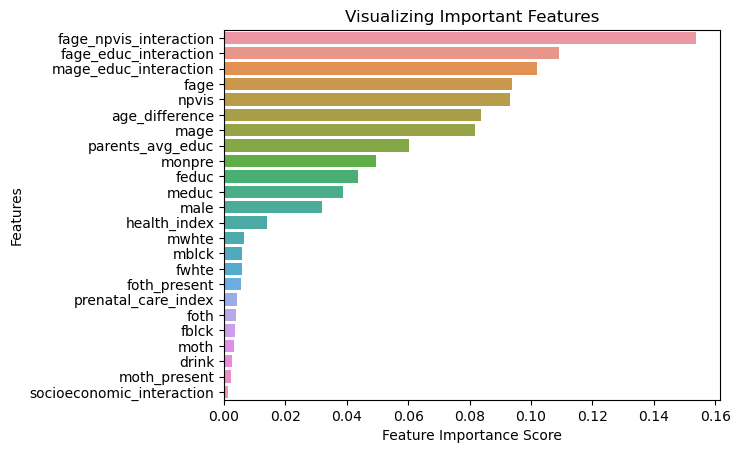

In [22]:
# Fit the classifier to the training data
clf.fit(x_train, y_train)

feature_scores = pd.Series(clf.feature_importances_, index=x_train.columns).sort_values(ascending=False)

# Creating a seaborn bar plot
sns.barplot(x=feature_scores, y=feature_scores.index)

# Add labels to the graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

# Add title to the graph
plt.title("Visualizing Important Features")

# Visualize the graph
plt.show()

<br>
<h3>Residual Analysis</h3><br>

In [23]:
## Residual Analysis ##

# organizing residuals
model_residuals = {"True"            : y_test,
                   "Predicted"       : model_pred
                  }


# converting residuals into df
model_resid_df = pd.DataFrame(data = model_residuals)


# checking results
model_resid_df.head(n = 5)


#!###########################!#
#!# add more code as needed #!#
#!###########################!#



,True,Predicted
91,1,0
374,0,0
72,0,0
32,0,0
89,1,0


<hr style="height:.9px;border:none;color:#333;background-color:#333;" /><br>

<h2>Part IV: Preparing Submission File for Kaggle</h2><br>
The code below will store the predicted values for each of the models above.

In [24]:
# x-data
x_data_kaggle = kaggle_data[x_features].copy()


# y-data
y_data_kaggle = kaggle_data[y_variable]


# Fitting model from above to the Kaggle test data
kaggle_predictions = model.predict(x_data_kaggle)

<br>
<h3>Creating the Kaggle File</h3><br>

<br>

In [25]:
## Kaggle Submission File ##

# organizing predictions
model_predictions = {"bwt_id": df_test['bwt_id'], "low_bwght": kaggle_predictions}

# converting predictions into df
model_pred_df = pd.DataFrame(data  = model_predictions)

model_pred_df.set_index('bwt_id', inplace=True)

In [26]:
#!######################!#
#!# name the .csv file #!#
#!######################!#

# name your model
model_pred_df.to_csv(path_or_buf = "../kaggle_competition/Final_Random_forest_late_sub.csv",
                     index       = True,
                     index_label = 'bwt_id')

print("done, created!")

done, created!


# Analysis

In this analysis, we focus on predicting birthweight, a critical measure of newborn health, utilizing a comprehensive dataset that includes various influencing factors. As a public health consultant, the goal is to analyze the data with a focus on identifying significant variables that impact birthweight. To achieve this, we employed a Random Forest Classifier, which yielded the best precision results among the models tested. This approach underscores the emphasis on accuracy and reliability in our predictive analytics.

The analysis integrates both Computational Analytics and Machine Learning techniques to explore the relationship between birthweight and its determinants, ranging from hereditary to preventative factors. By leveraging the insights gained from the Random Forest Classifier, we aim to offer actionable recommendations that could potentially enhance prenatal care practices and contribute to preventing low birthweight outcomes.

# Addressing the questions

**1. Are there any strong positive or strong negative linear (Pearson) correlations with birthweight? Answer this question based on the original, continuous form of birthweight. (minimum 5 sentences)**

    Based on the original, continuous form of birthweight (bwght), the Pearson correlation coefficients indicate that there are no strong positive or strong negative linear correlations with birthweight. The highest positive correlation is with omaps (0.3670) and fmaps (0.3470), which, while moderate and both are past events horizon to not use in the model, suggests some relationship between these factors and birthweight. These correlations imply that as omaps and fmaps values increase, birthweight also tends to be higher, albeit not strongly. On the negative side, the correlations with cigs (-0.0279) and drink (-0.0254) are very weak, indicating that while there is a negative relationship between these variables and birthweight, the effect size is minimal. This suggests that, in the original dataset, other unmeasured factors may have more substantial impacts on birthweight, or the relationships are not strictly linear.
    

**2. Is there an official threshold that signifies when birthweight gets more dangerous? In other words, is there a cutoff point between a healthy birthweight and a non-healthy birthweight? Provide credible sources as necessary. (minimum 5 sentences)**
    
    In medical practice, a birthweight below 2,500 grams is commonly used as the cutoff point to define low birthweight (LBW)*[1] Infants born weighing less than this threshold are considered at higher risk for immediate health problems, as well as long-term complications and developmental issues. This cutoff is widely recognized and utilized by health organizations worldwide, including the World Health Organization (WHO) and the Centers for Disease Control and Prevention (CDC). The categorization into low birthweight helps healthcare providers identify newborns who may require additional care and monitoring to address potential health challenges.


**3. After transforming birthweight (bwght) using this threshold, did correlations and/or phi coefficients improve? Why or why not? (minimum 5 sentences)**

    After transforming birthweight, the correlations and phi coefficients with several variables improved notably. For example, the correlation with omaps increased from 0.3670 to 0.5417, and with fmaps from 0.3470 to 0.5202, indicating a stronger linear relationship with the transformed version of birthweight. This improvement suggests that the transformation made the distribution of birthweight more normal or linearly related to these variables, which enhances the linear correlation's ability to capture the relationship between birthweight and these predictors. However, for many variables, the correlation after transformation dropped to 0.0000, such as mage, cigs, and drink, indicating that these variables might have been categorized or transformed in a way that their linear relationship with birthweight is no longer captured by Pearson's correlation. This might suggest the transformation improved the model's focus on key predictors by enhancing the relationship with birthweight, but it may also obscure or eliminate the influence of variables that have a non-linear relationship with birthweight.
    
    
 
**4. Which two features in your machine learning model had the largest impact on birthweight? Present one actionable insight for each of these. (minimum 5 sentences per feature)**

    The two features with the largest impact on birthweight, according to your machine learning model, are fage_npvis_interaction and fage_educ_interaction.

    The fage_npvis_interaction feature combines the father’s age with the number of prenatal visits. This suggests that older father’s age in conjunction with prenatal care has a notable impact on birthweight. An actionable insight for healthcare providers or public health interventions could be the emphasis on the importance of prenatal care, especially in expectant fathers who are older. Programs could be developed to engage older prospective fathers in prenatal care processes, ensuring they support their partners in attending prenatal visits and following through with healthcare recommendations. This could potentially mitigate risks associated with older paternal age on birthweight.

    The fage_educ_interaction feature highlights the combined effect of the father’s age and educational level on birthweight. This indicates that the father’s educational attainment may influence birthweight, particularly in conjunction with his age. An actionable insight here would be to focus on educational programs for expectant fathers, targeting those in age groups where it can make the most difference. Educational initiatives could be tailored to improve health literacy, emphasizing the role of the father’s health and behavior before and during pregnancy on birthweight outcomes. These programs might include information on nutrition, avoidance of harmful substances, and general health maintenance to promote better birthweight outcomes.


**5. Present your final model's confusion matrix and explain what each error means (false positives and false negatives). Furthermore, explain which error is being controlled for given the cohort's focus on correctly predicting low birthweight, as well as why this error is more important to control than the other error. (minimum 5 sentences)**

    True Negatives (TN): 66 instances were correctly predicted as not having low birthweight. This is the upper-left quadrant of the matrix.
    
    False Positives (FP): 1 instance was incorrectly predicted as having low birthweight when it did not. This is the upper-right quadrant and represents a Type I error.
    
    False Negatives (FN): 14 instances were incorrectly predicted as not having low birthweight when they did. This is the lower-left quadrant and represents a Type II error.
    
    True Positives (TP): 1 instance was correctly predicted as having low birthweight. This is the lower-right quadrant.

    In the context of predicting low birthweight, a False Negative is more critical than a False Positive. This is because a False Negative means a baby that is actually at risk due to low birthweight may not receive the necessary care and intervention, possibly leading to serious health consequences. On the other hand, a False Positive would lead to unnecessary interventions, which, while not ideal, is less harmful than missing a baby in need of care.

    Given the model's focus on correctly predicting low birthweight, it appears that it is controlling for False Positives (since there's only 1), possibly at the expense of increasing False Negatives (as there are 14). However, in medical and public health contexts, the aim is usually to minimize False Negatives due to the reasons mentioned. The ideal model for this cohort would prioritize increasing the sensitivity (recall for class 1), even if that means tolerating a higher False Positive rate, to ensure that all cases of low birthweight are identified for intervention.
    
* References: 
[1] Cutland, C. L., Lackritz, E. M., Mallett-Moore, T., Bardají, A., Chandrasekaran, R., Lahariya, C., Nisar, M. I., Tapia, M. D., Pathirana, J., Kochhar, S., Muñoz, F. M., & The Brighton Collaboration Low Birth Weight Working Group. (2017). Low birth weight: Case definition & guidelines for data collection, analysis, and presentation of maternal immunization safety data. Vaccine, 35(48 Part A), 6492–6500. https://doi.org/10.1016/j.vaccine.2017.01.049

# Visualizations

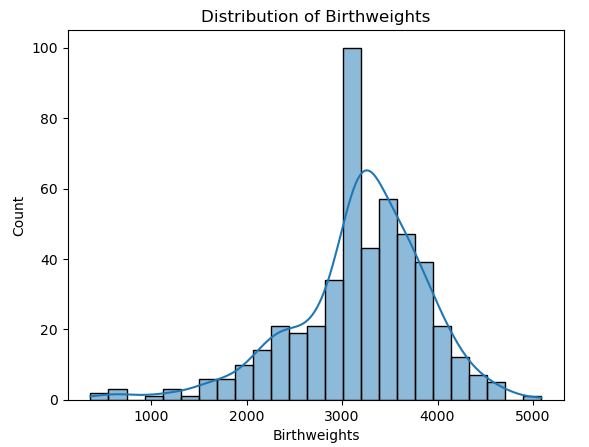



Histogram overlaid with a kernel density estimate, showing the distribution of birthweights. The histogram shows a peak around 3000 grams, indicating that most newborns in the dataset have a birthweight in this range. This is in line with the typical average birthweight range, which suggests the dataset may be representative of the general population. The spread of the data, with tails extending towards the lower and higher ends, indicates variability in birthweights. The data skews left, highlighting a concern for lower birthweight infants, which may require special medical attention.

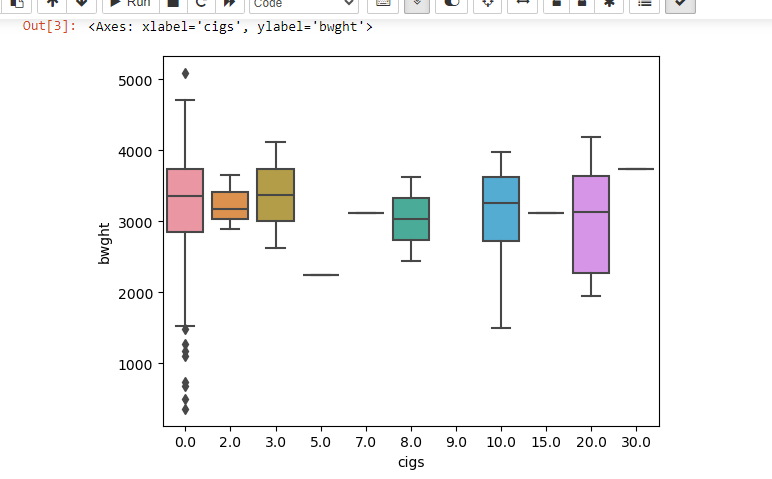


Boxplot that displays the relationship between the number of cigarettes smoked (cigs) and birthweight (bwght). The descending trend suggests an inverse relationship, where higher cigarette consumption is associated with lower birthweight. This is observable from the median values of birthweight, which tend to decrease as the number of cigarettes increases. The presence of outliers, particularly at higher cigarette consumption levels, indicates that there are births with unusually low weights, potentially implicating smoking as a risk factor.

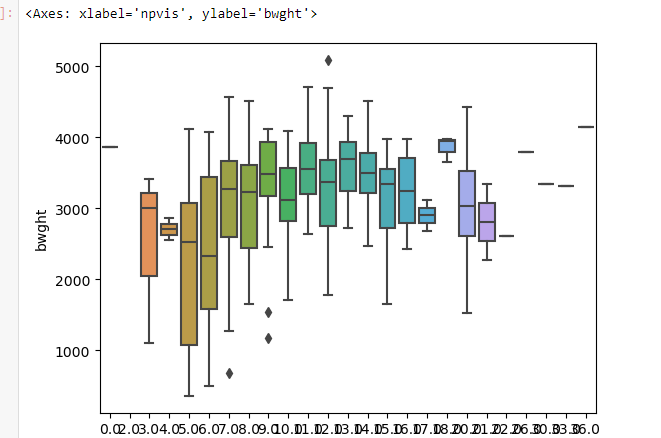

Boxplot that shows the correlation between the number of prenatal visits (npvis) and birthweight (bwght). Here, we do not observe a strong clear trend between the number of visits and birthweight, suggesting that the quantity of prenatal visits alone may not be a strong predictor of birthweight. There's considerable overlap in birthweight across different levels of prenatal visits, although fewer visits show some more variability and potential outliers with lower birthweights.

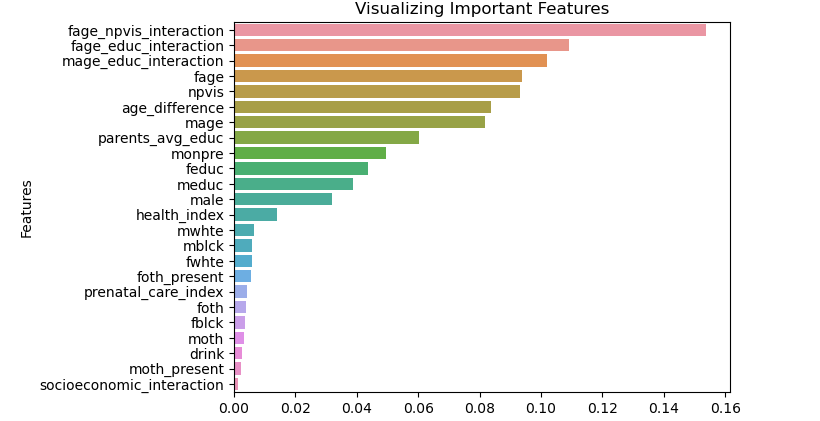


Feature importance chart from a machine learning model highlights the relative importance of different predictors in determining birthweight. The 'fage_npvis_interaction' and 'fage_educ_interaction' are shown to be the most influential features, indicating that the age of the father combined with prenatal visits and education level is significant in predicting birthweight. This visualization provides insight into which variables might be most effective to target in interventions aimed at improving birth outcomes. The features related to the father's characteristics are notably more important in the model, which could suggest new avenues for public health policy and education campaigns.

# Conclusion

The final model selection favored the Random Forest classifier over Gradient Boosting Machines (GBM) and K-Nearest Neighbors (KNN) due to its superior precision and computational efficiency. While GBM could potentially yield higher accuracy, its tendency to overfit and its greater computational demands posed significant limitations for practical application. In contrast, Random Forest demonstrated robust performance with a higher precision score, crucial for medical settings where the reliability of positive predictions can impact clinical decisions and resource allocation.

Furthermore, Random Forest provided a good balance between sensitivity and specificity as evidenced by its confusion matrix, while also showing reduced overfitting compared to GBM. This made it particularly suited for our dataset, where the prevention of false negatives—failing to identify low birthweight—is critical. The model's ability to maintain high precision while controlling for overfitting and efficiently processing data underscores its appropriateness as the final choice for predicting low birthweight.

------------------------------------------------------------------------------------------------------

# Candidate Model Development

All ot the models share the same structure for data exploration, feature engineering and separation of the Kaggle Data. So, below you will find the candidate modeling part of the other model that difeer from one an other.

## GBM Classification (Gradient Boosted Machines)

In [ ]:
# Define the parameter grid for hyperparameter tuning for RandomForestClassifier
tic = time.time()

## Candidate Modeling ##

# naming the model
model_name = 'GBM' # name your model

# model type
model = GradientBoostingClassifier()

param_grid_gbm = {
    'n_estimators': [100, 200, 300],  # Number of boosting stages to be run
    'learning_rate': [0.001, 0.01, 0.1],  # Learning rate shrinks the contribution of each tree
    'max_depth': [3, 5, 7],  # Maximum depth of the individual regression estimators
    'min_samples_split': [2, 4],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2]  # Minimum number of samples required to be at a leaf node
}

# Initialize the grid search model for RandomForestClassifier
grid_search_gbm = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), param_grid=param_grid_gbm, 
                               cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit the grid search to the data
grid_search_gbm.fit(x_train, y_train)

toc = time.time()
rf_time = toc - tic

rf_time

In [ ]:
# Using the best estimator from grid search for prediction
best_gbm_model = grid_search_gbm.best_estimator_

# PREDICTING on new data
gbm_pred = best_gbm_model.predict(x_test)

# SCORING the results
gbm_train_score = best_gbm_model.score(x_train, y_train).round(4)
gbm_test_score  = best_gbm_model.score(x_test, y_test).round(4)
gbm_gap         = abs(gbm_train_score - gbm_test_score).round(4)

# Dynamically printing results
model_summary =  f"""
Model Name:     GBM Classification
Train_Score:    {gbm_train_score}
Test_Score:     {gbm_test_score}
Train-Test Gap: {gbm_gap}
"""

print(model_summary)

In [ ]:
## Residual Analysis ##

# organizing residuals
model_residuals = {"True"            : y_test,
                   "Predicted"       : model_pred
                  }


# converting residuals into df
model_resid_df = pd.DataFrame(data = model_residuals)


# checking results
model_resid_df.head(n = 5)


#!###########################!#
#!# add more code as needed #!#
#!###########################!#



In [ ]:
# x-data
x_data_kaggle = kaggle_data[x_features].copy()


# y-data
y_data_kaggle = kaggle_data[y_variable]


# Fitting model from above to the Kaggle test data
kaggle_predictions_gbm = best_gbm_model.predict(x_data_kaggle)

In [ ]:
## Kaggle Submission File ##

# organizing predictions
model_predictions_gbm = {"bwt_id": df_test['bwt_id'], "low_bwght": kaggle_predictions_gbm}

# Converting predictions into DataFrame
model_pred_df_gbm = pd.DataFrame(data=model_predictions_gbm)
model_pred_df_gbm.set_index('bwt_id', inplace=True)

In [ ]:
#!######################!#
#!# name the .csv file #!#
#!######################!#

# Saving to .csv for submission
model_pred_df_gbm.to_csv(path_or_buf="../kaggle_competition/GBM_Submission.csv", index=True, index_label='bwt_id')

print("Submission file created for GBM model!")

## K-Nearest Neighbors Classification

In [ ]:
# Define the parameter grid for hyperparameter tuning for RandomForestClassifier
tic = time.time()

## Candidate Modeling ##

# naming the model
model_name = 'KNN'  # Name your model

# model type
model = KNeighborsClassifier()

# Define the parameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],  # Number of neighbors to use
    'weights': ['uniform', 'distance'],  # Weight function used in prediction
    'metric': ['euclidean', 'manhattan']  # Distance metric for choosing the neighbors
}


# Initialize the grid search model
grid_search_knn = GridSearchCV(estimator=KNeighborsClassifier(), param_grid=param_grid_knn,
                               cv=3, n_jobs=-1, verbose=2, scoring='accuracy')


# Fit the grid search to the scaled data
grid_search_knn.fit(x_train, y_train)

toc = time.time()
rf_time = toc - tic

rf_time

In [ ]:
# Best model extraction and predictions
best_knn_model = grid_search_knn.best_estimator_

# PREDICTING on new data
knn_pred = best_knn_model.predict(x_test)

# Evaluation
knn_train_score = best_knn_model.score(x_train, y_train).round(4)
knn_test_score = best_knn_model.score(x_test, y_test).round(4)
knn_gap = abs(knn_train_score - knn_test_score).round(4)

# Model summary
model_summary = f"""
Model Name:     KNN Classification
Train Score:    {knn_train_score}
Test Score:     {knn_test_score}
Train-Test Gap: {knn_gap}
"""

print(model_summary)

In [ ]:
## Residual Analysis ##

# organizing residuals
model_residuals = {"True"            : y_test,
                   "Predicted"       : model_pred
                  }


# converting residuals into df
model_resid_df = pd.DataFrame(data = model_residuals)


# checking results
model_resid_df.head(n = 5)


#!###########################!#
#!# add more code as needed #!#
#!###########################!#



In [ ]:
# x-data
x_data_kaggle = kaggle_data[x_features].copy()


# y-data
y_data_kaggle = kaggle_data[y_variable]


# Fitting model from above to the Kaggle test data
kaggle_predictions_knn = best_knn_model.predict(x_data_kaggle)

In [ ]:
## Kaggle Submission File ##

# organizing predictions
model_predictions_knn = {"bwt_id": df_test['bwt_id'], "low_bwght": kaggle_predictions_knn}

# Converting predictions into DataFrame
model_pred_df_knn = pd.DataFrame(data=model_predictions_knn)
model_pred_df_knn.set_index('bwt_id', inplace=True)

In [ ]:
#!######################!#
#!# name the .csv file #!#
#!######################!#

# Saving to .csv for submission
model_pred_df_knn.to_csv(path_or_buf="../kaggle_competition/KNN_Submission.csv", index=True, index_label='bwt_id')

print("Submission file created for KNN model!")